In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import os
import matplotlib.pylab as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

In [2]:
# read in the data
integrals = pd.read_csv('../data/integrals_20170323.txt',sep=',',header=None)
integral_ranges = pd.read_csv('../data/coculture_peak_ranges.txt',sep=',')
master = pd.read_csv('../data/merged_metadata.txt',sep='\t')
metabolite_tests = pd.read_csv('../results/all_vs_blank_diff_metabolites.txt',sep='\t')
CRAM_tests = pd.read_csv('../results/CRAM_all_diff_metabolites.txt',sep='\t')

In [3]:
# Add metabolite names to columns and merge the metadata with integrals
integrals.columns = integral_ranges['met_name']
mets = integrals.columns # grab metabolite names for future use
integrals['experiment_id'] = master['experiment_id']
all_data = pd.merge(master,integrals,on='experiment_id')

#remove non-growing samples
all_data = all_data.loc[~((all_data['Run'] == 2) & (all_data['species'].str.find('502') > -1))]
all_data = all_data.loc[~((all_data['Run'] == 3) & (all_data['species'].str.find('502') > -1))]
all_data = all_data.loc[~((all_data['Run'] == 3) & (all_data['species'].str.find('500') > -1))]
all_data = all_data.loc[~((all_data['Run'] == 3) & (all_data['species'].str.find('492') > -1))]
# remove run 4
all_data = all_data.loc[~(all_data['Run'] == 4)]
# remove 502
all_data = all_data.loc[all_data['species'].str.find('502') < 0]
# Set negative values as 0
all_data[mets] = all_data[mets].clip(0)

In [4]:
# since contamination was deemed as non-significant in any condition, we will set all qpcr values to
# 0 for the probes for species that were not inoculated in a culture.
qpcr_cols = all_data.columns[all_data.columns.str.find('qpcr') > -1]
for probe in qpcr_cols:
    species = probe.split('.')[-2]
    #not_this_species = [probename for probename in qpcr_cols if probename.find(species) < 0]
    all_data.loc[all_data['species'].str.find(species) < 0,probe] = 0

In [5]:
## Generate expected metabolite abundances
# First, center the metabolomics data to be relative to blank media
all_data[mets] = all_data[mets] - all_data.loc[all_data['species'] == '0'][mets].mean()
# for each species, convert each metabolite to an amount per unit biomass
single_species = all_data.loc[all_data['species'].str.find(',') < 0].copy()
species_names = [name for name in single_species['species'].unique() if name is not '0']

for species in species_names:
    qpcr_name = [col for col in single_species.columns if col.find(species) > -1][0]
    single_species.loc[single_species['species'] == species,mets] = \
        single_species.loc[single_species['species'] == species,mets].div(\
        single_species.loc[single_species['species'] == species,qpcr_name],axis='rows')

# for each species, for each metabolite, calculate an average yield
avg_yields = single_species.groupby(by='species')[mets].mean().T
# multiply the single species yields by the qpcr values for each species and sum for co-cultures
all_data_expected = all_data.copy()
all_data_expected[mets] = 0 # set to zero and we will use each entry to sum the expected values
                            # from each species
for species in species_names:
    qpcr_name = [col for col in single_species.columns if col.find(species) > -1][0]
    all_data_expected[mets] = all_data_expected[mets] + all_data_expected[qpcr_name].apply(lambda r: r * avg_yields[species])

In [6]:
# Scale the integrals to an absolute value between 0 and 1
for metabolite in mets:
    scaled_observed = all_data[metabolite]
    scaled_expected = all_data_expected[metabolite]
    max_observed = np.max(np.abs(scaled_observed))
    max_expected = np.max(np.abs(scaled_expected))
    scaled_observed /= np.max([max_observed,max_expected])
    scaled_expected /= np.max([max_observed,max_expected])
    all_data[metabolite] = scaled_observed
    all_data_expected[metabolite] = scaled_expected

In [7]:
# plotting of individual metabolite abundances
combinations = ['356','356,360','356,361','356,492','356,500','356,519','360',\
               '360,361','360,492','360,500','360,519','361','361,492','361,500',\
               '361,519','492','492,500','492,519','500','500,519',\
               '519']
sig_thresh = 0.05
expectation_diff = {}
red_cmap = plt.get_cmap('Reds')
blue_cmap = plt.get_cmap('Blues')
for metabolite in mets:
    print('plotting ' + metabolite)
    expectation_diff[metabolite] = {}
    fig, ax = plt.subplots()
    gridsize = 6 # grid will be 6x6 because we have 6 species
    x_count = 0
    y_count = 0
    patches = []

    for combo in combinations:
        met_combo_mean = all_data.loc[all_data['species'] == combo][metabolite].mean()
        if met_combo_mean > 0:
            met_combo_color = red_cmap(met_combo_mean)
        else:
            met_combo_color = blue_cmap(-1.0*met_combo_mean)
    
        # get expected metabolite abundance for this combination
        expected_mean = all_data_expected.loc[all_data_expected['species'] == combo][metabolite].mean()
        if expected_mean > 0:
            expected_color = red_cmap(expected_mean)
        else:
            expected_color = blue_cmap(-1.0*expected_mean)
        
    
        grid_x_pos = 1 - x_count/gridsize
        grid_y_pos = y_count/gridsize
        # if plotting a single species outcome, plot a rectangle. Otherwise, plot a triangle.
        if x_count == y_count:
            monoculture_rectangle = Polygon(((grid_x_pos,grid_y_pos),(grid_x_pos-1/gridsize,grid_y_pos),(grid_x_pos-1/gridsize,grid_y_pos+1/gridsize),(grid_x_pos,grid_y_pos+1/gridsize)),\
                            closed=True,edgecolor='black',facecolor=met_combo_color)
            plt.gca().add_patch(monoculture_rectangle)
        else: # plot the co-culture outcome and the expected outcome
            triangle = Polygon(((grid_x_pos,grid_y_pos),(grid_x_pos-1/gridsize,grid_y_pos),(grid_x_pos-1/gridsize,grid_y_pos+1/gridsize)),\
                           closed=True,edgecolor='black',facecolor=met_combo_color)
            # add expected triangle here:
            expected_triangle = Polygon(((grid_x_pos,grid_y_pos),(grid_x_pos-1/gridsize,grid_y_pos+1/gridsize),(grid_x_pos,grid_y_pos+1/gridsize)),\
                       closed=True,edgecolor='black',facecolor=expected_color)
            outline_rectangle = Polygon(((grid_x_pos,grid_y_pos),(grid_x_pos-1/gridsize,grid_y_pos),(grid_x_pos-1/gridsize,grid_y_pos+1/gridsize),(grid_x_pos,grid_y_pos+1/gridsize)),\
                        closed=True,edgecolor='black',facecolor='none')
            plt.gca().add_patch(triangle)
            plt.gca().add_patch(expected_triangle)
            plt.gca().add_patch(outline_rectangle)
        
            # get the result of the significance test (observed vs. expected) to annotate the plot
            diff_for_combo = CRAM_tests.loc[(CRAM_tests['combo'] == combo) & (CRAM_tests['met_order'] == metabolite)]
            p_for_met = diff_for_combo['combo_ps'].values[0]
            if p_for_met < sig_thresh:
                significant = True
            else:
                significant = False
            if significant:
                note = ax.text(grid_x_pos-0.7*1/gridsize, grid_y_pos+0.2*1/gridsize,'*',size=10)
            
            expectation_diff[metabolite][combo] = {}
            expectation_diff[metabolite][combo]['p'] = p_for_met
            expectation_diff[metabolite][combo]['difference'] = met_combo_mean - expected_mean
        x_count+=1
        if x_count == 6:
            y_count += 1 # go up one level
            x_count = 0 + y_count # reset to the rightmost x position at the new y level
    fig.set_size_inches(5,5)
    ax.axis('off')
    plt.savefig('../results/coculture_metabolome_plots/'+metabolite+'_cocultures.svg', bbox_inches='tight')
    plt.close()

plotting unknown1
plotting unknown2
plotting unknown3
plotting Butyrate
plotting Isovalerate
plotting Leucine
plotting Valine
plotting Isoleucine
plotting Propionate
plotting unknown4
plotting Ethanol
plotting Lactate
plotting Isocaproate
plotting unknown5
plotting Alanine
plotting unknown6
plotting Acetate
plotting unknown7
plotting unknown8
plotting Methionine
plotting unknown9
plotting Glutamate
plotting Isobutyrate
plotting Succinate
plotting 2-Oxoisocaproate
plotting Aspartate
plotting unknown10
plotting Asparagine
plotting Lysine
plotting Choline
plotting Proline
plotting Cystine
plotting unknown11
plotting Glycine
plotting Glycerol
plotting unknown12
plotting unknown13
plotting unknown14
plotting Betaine
plotting Serine
plotting Isopropanol
plotting Pyroglutamate
plotting Threonine
plotting Trehalose
plotting Lactose
plotting unknown15
plotting unknown16
plotting unknown17
plotting unknown18
plotting Uracil
plotting Uridine
plotting unknown19
plotting unknown20
plotting Cytosine

In [8]:
def plot_volcanoes(input_frame,combo='',summary_frame=False):
    fig, [ax1,ax2,ax3,ax4] = plt.subplots(1,4)
    subset = input_frame.copy()
    if len(combo) < 1:
        print("Plotting all combinations")
    else:
        subset = subset.loc[subset['combo'].str.contains(combo)]
    #combo = '492,500'
    #metabolite = 'Alanine'
    #subset = all_data_logged.loc[all_data_logged['combo'].str.contains(combo)]
    #subset = all_data_logged.loc[all_data_logged['metabolite'].str.contains(metabolite)]
    # get the species change columns for species involved in the combo
    species_1 = pd.Series([species[0] for species in subset['combo'].str.split(',')])
    species_2 = pd.Series([species[1] for species in subset['combo'].str.split(',')])
    subset['species_1_mono'] = subset.lookup(subset.index,species_1.values)
    subset['species_2_mono'] = subset.lookup(subset.index,species_2.values)
    map_to_change_code = {}
    for index in subset.index:
        if subset.get_value(index,'species_1_mono') < 0:
            if subset.get_value(index,'species_2_mono') < 0:
                # consumed by both
                map_to_change_code[index] = 'consumed_by_both'
            elif subset.get_value(index,'species_2_mono') == 0:
                # consumed by species 1 only
                map_to_change_code[index] = 'consumed_by_one'
            else:
                # consumed by species 1, produced by species 2
                map_to_change_code[index] = 'consumed_and_produced'
        elif subset.get_value(index,'species_1_mono') == 0:
            if subset.get_value(index,'species_2_mono') < 0:
                map_to_change_code[index] = 'consumed_by_one'
            elif subset.get_value(index,'species_2_mono') == 0:
                map_to_change_code[index] = 'no_change'
            else:
                map_to_change_code[index] = 'produced_by_one'
        else:
            if subset.get_value(index,'species_2_mono') < 0:
                map_to_change_code[index] = 'consumed_and_produced'
            elif subset.get_value(index,'species_2_mono') == 0:
                map_to_change_code[index] = 'produced_by_one'
            else:
                map_to_change_code[index] = 'produced_by_both'
    grey = (128.0/255.0,128.0/255.0,128.0/255.0)
    blue = (0,0,1.0)
    color_dict = {'consumed_by_both':blue,\
                 'consumed_by_one':blue,\
                 'consumed_and_produced':grey,\
                 'produced_by_one':grey,\
                 'produced_by_both':grey,\
                 'no_change':grey}
    map_as_series = pd.Series(map_to_change_code)
    subset['change_code'] = map_as_series

    # add co-culture metabolite abundance changes
    coculture_copy = pd.DataFrame()
    coculture_copy['metabolite'] = metabolite_tests['met_order']
    coculture_copy['combo'] = metabolite_tests['species_tested']
    coculture_copy['coculture_change'] = np.where(metabolite_tests['diff_avgs'] > 0, 1, -1)*np.where(metabolite_tests['met_ps'] > 0.05, 0, 1) # change to 1/-1
    print(len(subset))
    subset = subset.merge(coculture_copy)
    print(len(subset))
    
    alpha = 0.0
    alpha_dict = {'consumed_by_both':0.25,\
                 'consumed_by_one':0.25,\
                 'consumed_and_produced':alpha,\
                 'produced_by_one':alpha,\
                 'produced_by_both':alpha,\
                 'no_change':alpha}
    ax1.scatter(subset['difference'],subset['p'],facecolor=subset['change_code'].apply(lambda x: color_dict[x] + tuple([alpha_dict[x]])))
    ax1.set_ylim(bottom=0,top=ax1.get_ylim()[1])
    ax1.plot([0,0],[ax1.get_ylim()[0],ax1.get_ylim()[1]],'--',color='black')
    ax1.plot([ax1.get_xlim()[0],ax1.get_xlim()[1]],[1.3,1.3],'--',color='grey')
    #ax1.set_xlabel('Observed abundance - expected abundance',size=20)
    ax1.set_ylabel('-1 * log10(p-value)',size=20)
    ax1.set_title('Consumed in monoculture', size = 15)


    grey = (128.0/255.0,128.0/255.0,128.0/255.0)
    red = (204.0/255,0,0)
    color_dict = {'consumed_by_both':grey,\
                 'consumed_by_one':grey,\
                 'consumed_and_produced':grey,\
                 'produced_by_one':red,\
                 'produced_by_both':red,\
                 'no_change':grey}

    alpha_dict = {'consumed_by_both':alpha,\
                 'consumed_by_one':alpha,\
                 'consumed_and_produced':alpha,\
                 'produced_by_one':0.25,\
                 'produced_by_both':0.25,\
                 'no_change':alpha}
    ax2.scatter(subset['difference'],subset['p'],facecolor=subset['change_code'].apply(lambda x: color_dict[x] + tuple([alpha_dict[x]])))
    ax2.set_ylim(bottom=0,top=ax2.get_ylim()[1])
    ax2.plot([0,0],[ax2.get_ylim()[0],ax2.get_ylim()[1]],'--',color='black')
    ax2.plot([ax2.get_xlim()[0],ax2.get_xlim()[1]],[1.3,1.3],'--',color='grey')
    ax2.set_xlabel('Observed abundance - expected abundance',size=20)
    ax2.set_title('Produced in monoculture', size=15)
    #ax2.set_ylabel('-1 * log10(p-value)',size=20)


    grey = (128.0/255.0,128.0/255.0,128.0/255.0)
    green = (0,204.0/255,0)
    color_dict = {'consumed_by_both':grey,\
                 'consumed_by_one':grey,\
                 'consumed_and_produced':green,\
                 'produced_by_one':grey,\
                 'produced_by_both':grey,\
                 'no_change':grey}

    alpha_dict = {'consumed_by_both':alpha,\
                 'consumed_by_one':alpha,\
                 'consumed_and_produced':0.25,\
                 'produced_by_one':alpha,\
                 'produced_by_both':alpha,\
                 'no_change':alpha}
    ax3.scatter(subset['difference'],subset['p'],facecolor=subset['change_code'].apply(lambda x: color_dict[x] + tuple([alpha_dict[x]])))
    ax3.set_ylim(bottom=0,top=ax3.get_ylim()[1])
    ax3.plot([0,0],[ax3.get_ylim()[0],ax3.get_ylim()[1]],'--',color='black')
    ax3.plot([ax3.get_xlim()[0],ax3.get_xlim()[1]],[1.3,1.3],'--',color='grey')
    ax3.set_title('Consumed and Produced',size=15)
    #ax3.set_xlabel('Observed abundance - expected abundance',size=20)
    #ax3.set_ylabel('-1 * log10(p-value)',size=20)

    yellow = (0,204.0/255,204.0/255)
    color_dict = {'consumed_by_both':grey,\
                 'consumed_by_one':grey,\
                 'consumed_and_produced':grey,\
                 'produced_by_one':grey,\
                 'produced_by_both':grey,\
                 'no_change':yellow}

    alpha_dict = {'consumed_by_both':alpha,\
                 'consumed_by_one':alpha,\
                 'consumed_and_produced':alpha,\
                 'produced_by_one':alpha,\
                 'produced_by_both':alpha,\
                 'no_change':0.25}
    ax4.scatter(subset['difference'],subset['p'],facecolor=subset['change_code'].apply(lambda x: color_dict[x] + tuple([alpha_dict[x]])))
    ax4.set_ylim(bottom=0,top=ax3.get_ylim()[1])
    ax4.plot([0,0],[ax4.get_ylim()[0],ax4.get_ylim()[1]],'--',color='black')
    ax4.plot([ax4.get_xlim()[0],ax4.get_xlim()[1]],[1.3,1.3],'--',color='grey')
    ax4.set_title('No Change',size=15)

    fig.set_size_inches(20,5)
    
    # return summary metrics
    if summary_frame:
        return subset

    
def calculate_metrics(subset):
    # get significantly different consumed mets
    pos_sig_consumed = len(subset.loc[(subset['p'] > -1.0*np.log10(0.05)) &\
                                      (subset['difference'] > 0) &\
                                      ((subset['change_code'] == 'consumed_by_one') |\
                                       (subset['change_code'] == 'consumed_by_both'))])
    neg_sig_consumed = len(subset.loc[(subset['p'] > -1.0*np.log10(0.05)) &\
                                      (subset['difference'] < 0) &\
                                      ((subset['change_code'] == 'consumed_by_one') |\
                                       (subset['change_code'] == 'consumed_by_both'))])
    # same for produced
    pos_sig_produced = len(subset.loc[(subset['p'] > -1.0*np.log10(0.05)) &\
                                      (subset['difference'] > 0) &\
                                      ((subset['change_code'] == 'produced_by_one') |\
                                       (subset['change_code'] == 'produced_by_both'))])
    neg_sig_produced = len(subset.loc[(subset['p'] > -1.0*np.log10(0.05)) &\
                                      (subset['difference'] < 0) &\
                                      ((subset['change_code'] == 'produced_by_one') |\
                                       (subset['change_code'] == 'produced_by_both'))])
    #same for potentially cross-fed
    pos_sig_crossfed = len(subset.loc[(subset['p'] > -1.0*np.log10(0.05)) &\
                                      (subset['difference'] > 0) &\
                                      (subset['change_code'] == 'consumed_and_produced')])
    neg_sig_crossfed = len(subset.loc[(subset['p'] > -1.0*np.log10(0.05)) &\
                                      (subset['difference'] < 0) &\
                                      (subset['change_code'] == 'consumed_and_produced')])
    # same for no change
    pos_sig_nochange = len(subset.loc[(subset['p'] > -1.0*np.log10(0.05)) &\
                                      (subset['difference'] > 0) &\
                                      (subset['change_code'] == 'no_change')])
    neg_sig_nochange = len(subset.loc[(subset['p'] > -1.0*np.log10(0.05)) &\
                                      (subset['difference'] < 0) &\
                                      (subset['change_code'] == 'no_change')])

    # Repeat for non-significant mets
    pos_nonsig_consumed = len(subset.loc[(subset['p'] < -1.0*np.log10(0.05)) &\
                                      (subset['difference'] > 0) &\
                                      ((subset['change_code'] == 'consumed_by_one') |\
                                       (subset['change_code'] == 'consumed_by_both'))])
    neg_nonsig_consumed = len(subset.loc[(subset['p'] < -1.0*np.log10(0.05)) &\
                                      (subset['difference'] < 0) &\
                                      ((subset['change_code'] == 'consumed_by_one') |\
                                       (subset['change_code'] == 'consumed_by_both'))])
    # same for produced
    pos_nonsig_produced = len(subset.loc[(subset['p'] < -1.0*np.log10(0.05)) &\
                                      (subset['difference'] > 0) &\
                                      ((subset['change_code'] == 'produced_by_one') |\
                                       (subset['change_code'] == 'produced_by_both'))])
    neg_nonsig_produced = len(subset.loc[(subset['p'] < -1.0*np.log10(0.05)) &\
                                      (subset['difference'] < 0) &\
                                      ((subset['change_code'] == 'produced_by_one') |\
                                       (subset['change_code'] == 'produced_by_both'))])
    #same for potentially cross-fed
    pos_nonsig_crossfed = len(subset.loc[(subset['p'] < -1.0*np.log10(0.05)) &\
                                      (subset['difference'] > 0) &\
                                      (subset['change_code'] == 'consumed_and_produced')])
    neg_nonsig_crossfed = len(subset.loc[(subset['p'] < -1.0*np.log10(0.05)) &\
                                      (subset['difference'] < 0) &\
                                      (subset['change_code'] == 'consumed_and_produced')])
    # same for no change
    pos_nonsig_nochange = len(subset.loc[(subset['p'] < -1.0*np.log10(0.05)) &\
                                      (subset['difference'] > 0) &\
                                      (subset['change_code'] == 'no_change')])
    neg_nonsig_nochange = len(subset.loc[(subset['p'] < -1.0*np.log10(0.05)) &\
                                      (subset['difference'] < 0) &\
                                      (subset['change_code'] == 'no_change')])
    all_metrics = {'pos_sig_consumed':pos_sig_consumed,'pos_sig_produced':pos_sig_produced,\
                   'pos_sig_nochange':pos_sig_nochange,'pos_sig_crossfed':pos_sig_crossfed,\
                  'neg_sig_consumed':neg_sig_consumed,'neg_sig_produced':neg_sig_produced,\
                   'neg_sig_nochange':neg_sig_nochange,'neg_sig_crossfed':neg_sig_crossfed,\
                  'pos_nonsig_consumed':pos_nonsig_consumed,'pos_nonsig_produced':pos_nonsig_produced,\
                   'pos_nonsig_nochange':pos_nonsig_nochange,'pos_nonsig_crossfed':pos_nonsig_crossfed,\
                  'neg_nonsig_consumed':neg_nonsig_consumed,'neg_nonsig_produced':neg_nonsig_produced,\
                   'neg_nonsig_nochange':neg_nonsig_nochange,'neg_nonsig_crossfed':neg_nonsig_crossfed}
    return all_metrics

In [9]:
# reformat data for volcano plots
volcano_data = []
for metabolite in expectation_diff.keys():
    data = pd.DataFrame(expectation_diff[metabolite]).T
    data['metabolite'] = metabolite
    data = data.reset_index()
    data = data.rename(columns={'index':'combo'})
    if len(volcano_data) < 1:
        volcano_data = data
    else:
        volcano_data = pd.concat([volcano_data,data])

volcano_data_logged = volcano_data.copy()
volcano_data_logged['p'] = -1*np.log10(volcano_data_logged['p'])

for species in ['356','360','361','492','500','519']:
    species_mono_diffs = metabolite_tests.loc[metabolite_tests['species_tested'] == species]
    change = {}
    for metabolite in list(set(species_mono_diffs['met_order'])):
        # get the integer indicating change for metabolite (-1,0, or 1)
        met_only = species_mono_diffs.loc[species_mono_diffs['met_order'] == metabolite]
        if met_only.get_value(met_only.index[0],'met_ps') < sig_thresh:
            if met_only.get_value(met_only.index[0],'diff_avgs') > 0:
                # metabolite was produced
                change[metabolite] = 1
            else:
                change[metabolite] = -1
        else:
            change[metabolite] = 0
    # convert to a dataframe, then add the column to the coculture results
    species_monoculture_change_df = pd.DataFrame(list(change.items()),columns=['metabolite','change'])
    volcano_data_logged = volcano_data_logged.merge(species_monoculture_change_df,on='metabolite')
    volcano_data_logged = volcano_data_logged.rename(columns={'change':species})
    
        
volcano_data_logged

,combo,difference,p,metabolite,356,360,361,492,500,519
0,"356,360",-0.206714,2.247330,Tryptophan,0,-1,0,-1,0,-1
1,"356,361",-0.006070,-0.000000,Tryptophan,0,-1,0,-1,0,-1
2,"356,492",-0.107990,0.293189,Tryptophan,0,-1,0,-1,0,-1
3,"356,500",-0.050501,0.761059,Tryptophan,0,-1,0,-1,0,-1
4,"356,519",0.367019,2.247330,Tryptophan,0,-1,0,-1,0,-1
5,"360,361",0.041102,0.026148,Tryptophan,0,-1,0,-1,0,-1
6,"360,492",-0.098382,0.358757,Tryptophan,0,-1,0,-1,0,-1
7,"360,500",-0.067562,1.148211,Tryptophan,0,-1,0,-1,0,-1
8,"360,519",0.142368,0.638416,Tryptophan,0,-1,0,-1,0,-1
9,"361,492",0.051150,0.210110,Tryptophan,0,-1,0,-1,0,-1


Plotting all combinations
1290
1290
Plotting all combinations
430
430


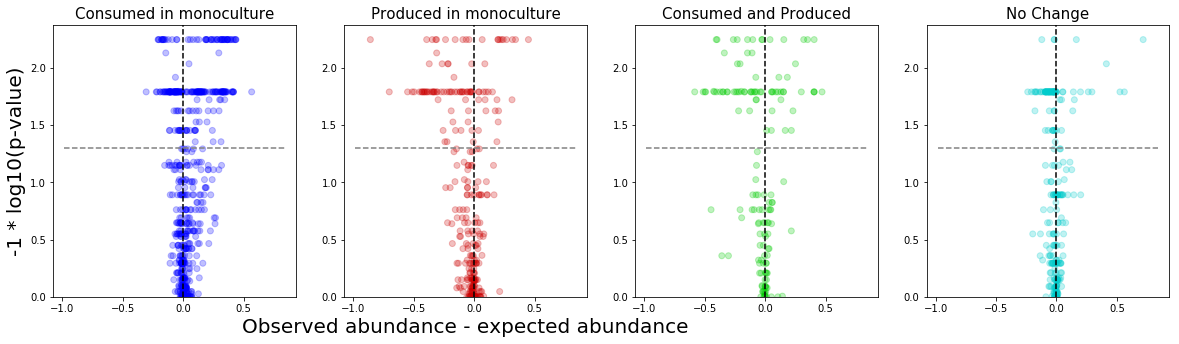

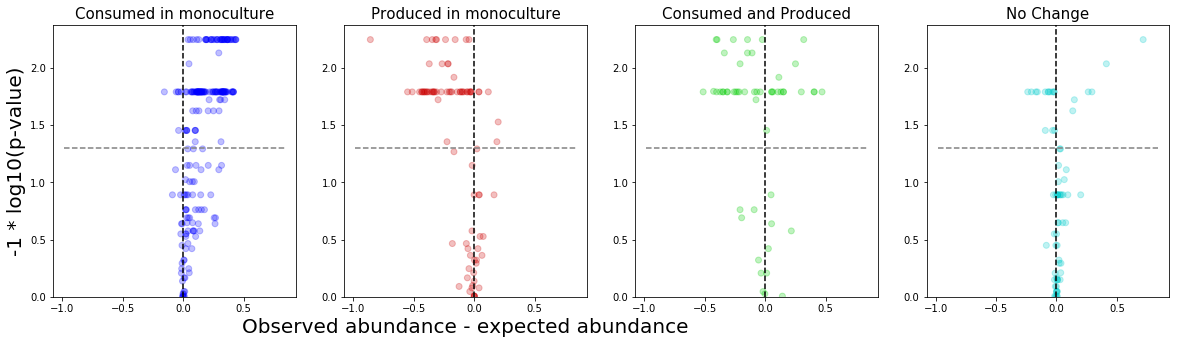

In [121]:
summary_frame_all = plot_volcanoes(volcano_data_logged,summary_frame=True)
plt.savefig('../results/all_volcano.svg')
overall_metrics = calculate_metrics(summary_frame_all)
# generate another summary frame that doesn't contain ASF361 and calculate metrics
summary_no361 = summary_frame_all.loc[summary_frame['combo'].str.find('361') < 0]
metrics_no361 = calculate_metrics(summary_no361)
# generate another summary frame that only contains pairs with a positive interaction, and another that contains the
# rest of the pairs
positive_pairs = ['356,519','361,492','361,500','361,519','492,519'] # these are pairs that had a positive interaction
# according to FDR-corrected p value < 0.10
summary_positives = volcano_data_logged.loc[volcano_data_logged['combo'].isin(positive_pairs)]
summary_positives_frame = plot_volcanoes(summary_positives,summary_frame=True)
metrics_only_positives = calculate_metrics(summary_positives_frame)
plt.savefig('../results/volcano_only_positives.svg')

In [91]:
summary_frame.loc[(summary_frame['change_code'] == 'consumed_and_produced') & (summary_frame['p'] < 1.3)]
sum(summary_frame.loc[summary_frame['change_code'] == 'no_change','coculture_change'] <0)

90

86
86


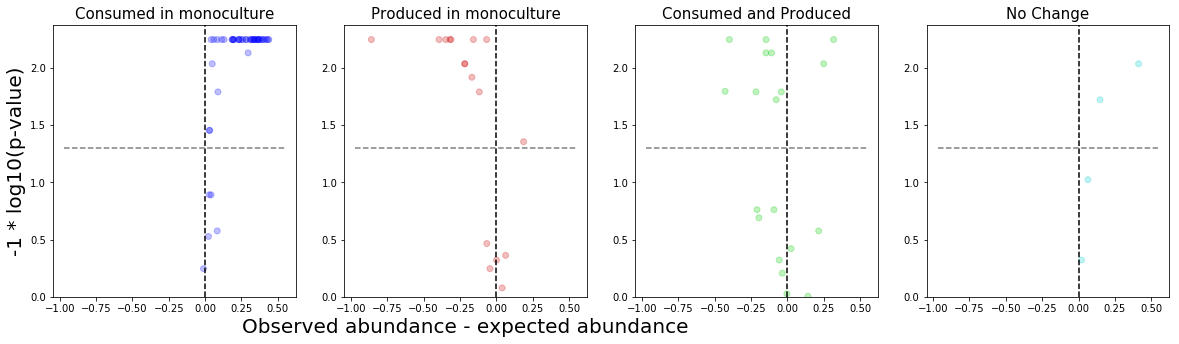

In [77]:
summary_frame = plot_volcanoes(volcano_data_logged,combo='356,519',summary_frame=True)
plt.savefig('../results/volcano_356_519.svg')


In [74]:
summary_frame.loc[(summary_frame['change_code'] == 'consumed_and_produced')].sort_values(by='difference')

,combo,difference,p,metabolite,356,360,361,492,500,519,species_1_mono,species_2_mono,change_code,coculture_change
16,"356,519",-0.428168,1.795146,unknown18,1,-1,0,0,1,-1,1,-1,consumed_and_produced,0
1,"356,519",-0.399001,2.247330,Hypoxanthine,1,1,1,1,1,-1,1,-1,consumed_and_produced,1
32,"356,519",-0.216076,1.790367,Isovalerate,1,-1,-1,1,0,-1,1,-1,consumed_and_produced,1
8,"356,519",-0.208903,0.761059,unknown3,1,-1,0,0,0,-1,1,-1,consumed_and_produced,1
13,"356,519",-0.195833,0.690375,Isocaproate,1,-1,-1,0,0,-1,1,-1,consumed_and_produced,1
18,"356,519",-0.147582,2.130776,Proline,-1,0,-1,0,0,1,-1,1,consumed_and_produced,1
67,"356,519",-0.147177,2.247330,Formate,-1,-1,1,-1,1,1,-1,1,consumed_and_produced,1
78,"356,519",-0.109419,2.130776,unknown6,1,-1,0,1,1,-1,1,-1,consumed_and_produced,1
70,"356,519",-0.092309,0.761059,unknown1,1,-1,0,1,0,-1,1,-1,consumed_and_produced,0
20,"356,519",-0.077159,1.721769,AMP,1,1,1,-1,-1,-1,1,-1,consumed_and_produced,0


86
86


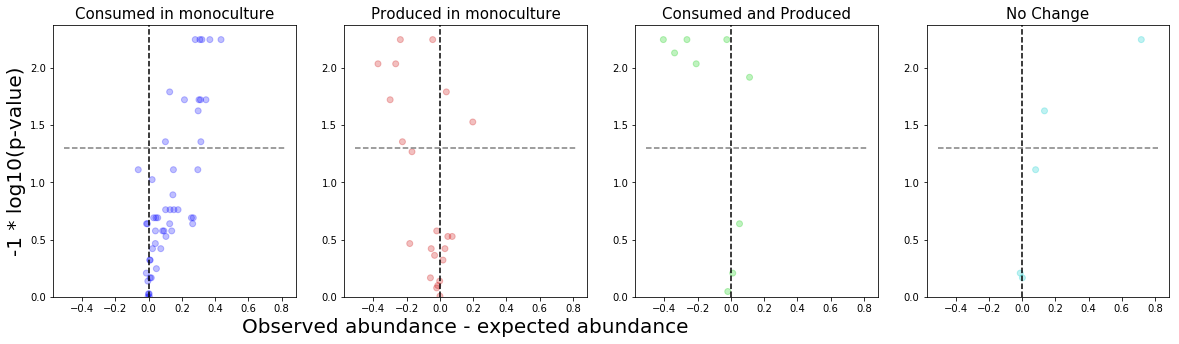

In [76]:
summary_frame = plot_volcanoes(volcano_data_logged,combo='361,519',summary_frame=True)
plt.savefig('../results/volcano_361_519.svg')


In [71]:
summary_frame.loc[(summary_frame['change_code'] == 'consumed_by_one')]

,combo,difference,p,metabolite,356,360,361,492,500,519,species_1_mono,species_2_mono,change_code,coculture_change
0,"361,519",0.145701,0.891049,Tryptophan,0,-1,0,-1,0,-1,0,-1,consumed_by_one,-1
5,"361,519",0.040205,0.465365,Threonine,-1,0,0,-1,0,-1,0,-1,consumed_by_one,-1
8,"361,519",-0.013856,0.206929,unknown3,1,-1,0,0,0,-1,0,-1,consumed_by_one,-1
14,"361,519",0.023040,0.420689,unknown25,0,-1,0,-1,0,-1,0,-1,consumed_by_one,-1
16,"361,519",0.020946,1.023902,unknown18,1,-1,0,0,1,-1,0,-1,consumed_by_one,-1
21,"361,519",-0.004797,0.137240,Serine,-1,0,0,-1,0,-1,0,-1,consumed_by_one,-1
24,"361,519",0.046572,0.245981,Asparagine,0,0,0,0,0,-1,0,-1,consumed_by_one,-1
26,"361,519",0.015766,0.165879,unknown33,0,-1,0,-1,0,-1,0,-1,consumed_by_one,-1
28,"361,519",0.297765,1.624813,Nicotinamide,-1,-1,-1,0,-1,0,-1,0,consumed_by_one,-1
29,"361,519",0.043527,0.690375,Cystine,-1,-1,0,-1,0,-1,0,-1,consumed_by_one,-1


In [57]:
summary_frame.loc[(summary_frame['change_code'] == 'produced_by_one') & (summary_frame['p'] > 1.25)]

,combo,difference,p,metabolite,356,360,361,492,500,519,species_1_mono,species_2_mono,change_code,coculture_change
6,"361,519",-0.237178,2.247330,Choline,-1,-1,0,-1,0,1,0,1,produced_by_one,-1
36,"361,519",0.039467,1.790367,Urocanate,0,0,0,0,0,1,0,1,produced_by_one,1
42,"361,519",-0.042754,2.247330,unknown32,1,0,1,1,1,0,1,0,produced_by_one,-1
74,"361,519",-0.224684,1.354921,Uracil,-1,-1,1,1,0,0,1,0,produced_by_one,1
83,"361,519",-0.298615,1.721769,Nicotinate,1,1,1,0,1,0,1,0,produced_by_one,1
84,"361,519",0.198457,1.527588,Cytosine,0,1,1,0,0,0,1,0,produced_by_one,1
85,"361,519",-0.167228,1.267598,unknown8,0,0,0,0,0,1,0,1,produced_by_one,1


In [70]:
all_data[['species','Valine']].groupby(by='species').mean()

,Valine
species,
0,4.087442e-17
356,-2.687670e-01
"356,360",-4.898105e-01
"356,361",-7.348779e-02
"356,492",-4.249078e-01
"356,500",-4.360891e-01
"356,519",-3.480638e-01
360,2.791546e-02
"360,361",-4.947112e-02


86
86


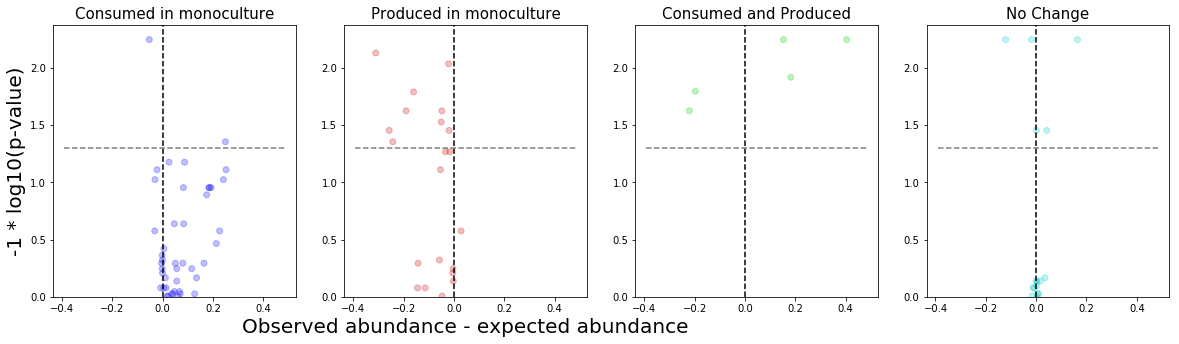

In [78]:
summary_frame = plot_volcanoes(volcano_data_logged,combo='360,361',summary_frame=True)

In [84]:
summary_frame.loc[summary_frame['change_code'] == 'no_change']

,combo,difference,p,metabolite,356,360,361,492,500,519,species_1_mono,species_2_mono,change_code,coculture_change
4,"360,361",0.010316,0.026148,Valine,-1,0,0,0,0,1,0,0,no_change,-1
5,"360,361",0.000432,0.137240,Threonine,-1,0,0,-1,0,-1,0,0,no_change,-1
10,"360,361",-0.007354,0.077766,Glutamate,0,0,0,0,-1,1,0,0,no_change,0
17,"360,361",0.016395,0.137240,Lysine,0,0,0,0,0,1,0,0,no_change,-1
21,"360,361",-0.018179,2.247330,Serine,-1,0,0,-1,0,-1,0,0,no_change,-1
24,"360,361",0.002158,0.098793,Asparagine,0,0,0,0,0,-1,0,0,no_change,0
35,"360,361",-0.012543,0.077766,unknown5,-1,0,0,0,0,0,0,0,no_change,0
36,"360,361",-0.015236,0.005829,Urocanate,0,0,0,0,0,1,0,0,no_change,0
39,"360,361",0.004077,-0.000000,Leucine,-1,0,0,0,0,-1,0,0,no_change,-1
44,"360,361",0.000871,1.453666,Propionate,1,0,0,0,0,1,0,0,no_change,0


86
86


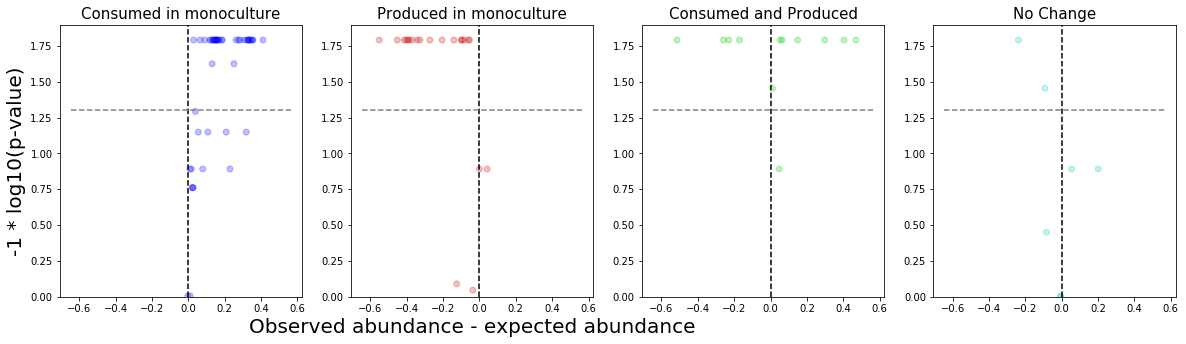

In [92]:
summary_frame = plot_volcanoes(volcano_data_logged,combo='492,519',summary_frame=True)

86
86


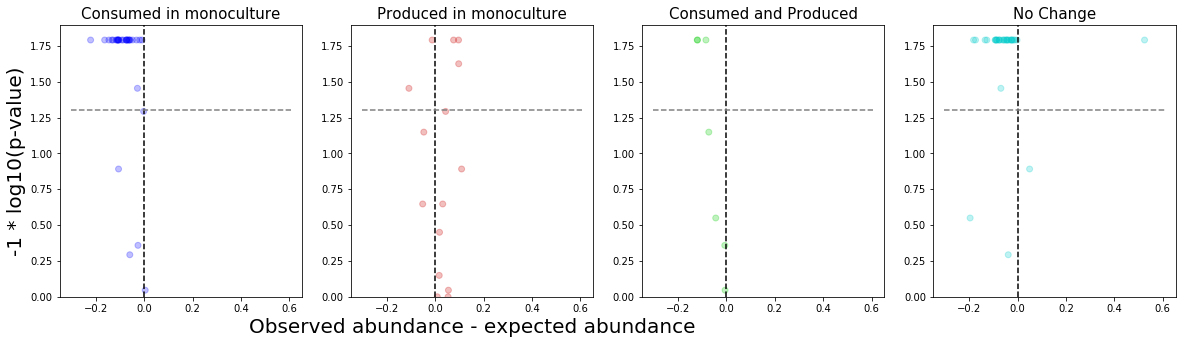

In [99]:
summary_frame = plot_volcanoes(volcano_data_logged,combo='492,500',summary_frame=True)

In [52]:
overall_metrics

{'neg_nonsig_consumed': 158,
 'neg_nonsig_crossfed': 46,
 'neg_nonsig_nochange': 82,
 'neg_nonsig_produced': 120,
 'neg_sig_consumed': 94,
 'neg_sig_crossfed': 45,
 'neg_sig_nochange': 67,
 'neg_sig_produced': 71,
 'pos_nonsig_consumed': 221,
 'pos_nonsig_crossfed': 32,
 'pos_nonsig_nochange': 71,
 'pos_nonsig_produced': 60,
 'pos_sig_consumed': 151,
 'pos_sig_crossfed': 28,
 'pos_sig_nochange': 17,
 'pos_sig_produced': 27}

In [142]:
#94+45+67+71
151+28+17+27

223

In [109]:

metrics_only_positives

{'neg_nonsig_consumed': 14,
 'neg_nonsig_crossfed': 7,
 'neg_nonsig_nochange': 13,
 'neg_nonsig_produced': 17,
 'neg_sig_consumed': 6,
 'neg_sig_crossfed': 26,
 'neg_sig_nochange': 14,
 'neg_sig_produced': 51,
 'pos_nonsig_consumed': 61,
 'pos_nonsig_crossfed': 6,
 'pos_nonsig_nochange': 36,
 'pos_nonsig_produced': 15,
 'pos_sig_consumed': 138,
 'pos_sig_crossfed': 15,
 'pos_sig_nochange': 6,
 'pos_sig_produced': 5}

In [54]:
# Make a table for the overall summary results
# get total metabolites that violate CRAM
all_conditions = [key for key in overall_metrics.keys()]
violators = [key for key in overall_metrics.keys() if key.find('_sig_') > -1]
consumed = [key for key in overall_metrics.keys() if key.find('consumed') > -1]
produced = [key for key in overall_metrics.keys() if key.find('produced') > -1]
total_tests = sum([overall_metrics[key] for key in all_conditions])
total_violations = sum([overall_metrics[key] for key in violators])
print('total CRAM violations: ' + str(total_violations) + '/' + str(total_tests))

print('Consumed metabolites less abundant than expected: ' + \
      str(overall_metrics['neg_sig_consumed']) + '/' + str(total_tests) + \
      ' (' + str(100*np.round(overall_metrics['neg_sig_consumed']/total_tests,3)) + '%)')
print('Consumed metabolites more abundant than expected: ' + \
      str(overall_metrics['pos_sig_consumed']) + '/' + str(total_tests) + \
      ' (' + str(100*np.round(overall_metrics['pos_sig_consumed']/total_tests,3)) + '%)')
print('Produced metabolites less abundant than expected: ' + \
      str(overall_metrics['neg_sig_produced']) + '/' + str(total_tests) + \
      ' (' + str(100*np.round(overall_metrics['neg_sig_produced']/total_tests,3)) + '%)')
print('Produced metabolites more abundant than expected: ' + \
      str(overall_metrics['pos_sig_produced']) + '/' + str(total_tests) + \
      ' (' + str(100*np.round(overall_metrics['pos_sig_produced']/total_tests,3)) + '%)')

total_consumed = sum([overall_metrics[key] for key in consumed])
total_produced = sum([overall_metrics[key] for key in produced])
print('Total consumed metabolites: ' + str(total_consumed))
print('Total produced metabolites: ' + str(total_produced))

total CRAM violations: 500/1290
Consumed metabolites less abundant than expected: 94/1290 (7.3%)
Consumed metabolites more abundant than expected: 151/1290 (11.7%)
Produced metabolites less abundant than expected: 71/1290 (5.5%)
Produced metabolites more abundant than expected: 27/1290 (2.1%)
Total consumed metabolites: 624
Total produced metabolites: 278


In [111]:
# repeat for the positive interactors only
all_conditions = [key for key in metrics_only_positives.keys()]
violators = [key for key in metrics_only_positives.keys() if key.find('_sig_') > -1]
consumed = [key for key in metrics_only_positives.keys() if key.find('consumed') > -1]
produced = [key for key in metrics_only_positives.keys() if key.find('produced') > -1]
total_tests = sum([metrics_only_positives[key] for key in all_conditions])
total_violations = sum([metrics_only_positives[key] for key in violators])
print('total CRAM violations: ' + str(total_violations) + '/' + str(total_tests))

print('Consumed metabolites less abundant than expected: ' + \
      str(metrics_only_positives['neg_sig_consumed']) + '/' + str(total_tests) + \
      ' (' + str(100*np.round(metrics_only_positives['neg_sig_consumed']/total_tests,3)) + '%)')
print('Consumed metabolites more abundant than expected: ' + \
      str(metrics_only_positives['pos_sig_consumed']) + '/' + str(total_tests) + \
      ' (' + str(100*np.round(metrics_only_positives['pos_sig_consumed']/total_tests,3)) + '%)')
print('Produced metabolites less abundant than expected: ' + \
      str(metrics_only_positives['neg_sig_produced']) + '/' + str(total_tests) + \
      ' (' + str(100*np.round(metrics_only_positives['neg_sig_produced']/total_tests,3)) + '%)')
print('Produced metabolites more abundant than expected: ' + \
      str(metrics_only_positives['pos_sig_produced']) + '/' + str(total_tests) + \
      ' (' + str(100*np.round(metrics_only_positives['pos_sig_produced']/total_tests,3)) + '%)')

total_consumed = sum([metrics_only_positives[key] for key in consumed])
total_produced = sum([metrics_only_positives[key] for key in produced])
print('Total consumed metabolites: ' + str(total_consumed))
print('Total produced metabolites: ' + str(total_produced))

total CRAM violations: 261/430
Consumed metabolites less abundant than expected: 6/430 (1.4%)
Consumed metabolites more abundant than expected: 138/430 (32.1%)
Produced metabolites less abundant than expected: 51/430 (11.9%)
Produced metabolites more abundant than expected: 5/430 (1.2%)
Total consumed metabolites: 219
Total produced metabolites: 88


In [123]:
print(sum(summary_frame_all.loc[summary_frame_all['change_code'] == 'no_change','coculture_change'] < 0))
print(sum(summary_positives_frame.loc[summary_positives_frame['change_code'] == 'no_change','coculture_change'] < 0))
print(sum(summary_frame_all.loc[summary_frame_all['change_code'] == 'no_change','coculture_change'] > 0))
print(sum(summary_positives_frame.loc[summary_positives_frame['change_code'] == 'no_change','coculture_change'] > 0))

90
30
15
7


In [164]:
summary_positives_frame.loc[(summary_positives_frame['change_code'] == 'consumed_and_produced') &\
                           (summary_positives_frame['combo'] == '356,519')].sort_values(by='p')

,combo,difference,p,metabolite,356,360,361,492,500,519,species_1_mono,species_2_mono,change_code,coculture_change
20,"356,519",0.141166,0.005829,Valine,-1,0,0,0,0,1,-1,1,consumed_and_produced,-1
30,"356,519",-0.003691,0.026148,Choline,-1,-1,0,-1,0,1,-1,1,consumed_and_produced,1
190,"356,519",-0.035085,0.206929,Tyramine,-1,1,0,0,0,1,-1,1,consumed_and_produced,1
15,"356,519",-0.056297,0.320898,UMP,1,1,1,0,0,-1,1,-1,consumed_and_produced,-1
115,"356,519",0.025341,0.420689,Butyrate,1,-1,-1,1,0,-1,1,-1,consumed_and_produced,-1
360,"356,519",0.215047,0.575795,Isobutyrate,1,-1,-1,0,-1,-1,1,-1,consumed_and_produced,1
65,"356,519",-0.195833,0.690375,Isocaproate,1,-1,-1,0,0,-1,1,-1,consumed_and_produced,1
40,"356,519",-0.208903,0.761059,unknown3,1,-1,0,0,0,-1,1,-1,consumed_and_produced,1
350,"356,519",-0.092309,0.761059,unknown1,1,-1,0,1,0,-1,1,-1,consumed_and_produced,0
100,"356,519",-0.077159,1.721769,AMP,1,1,1,-1,-1,-1,1,-1,consumed_and_produced,0


In [166]:
summary_positives_frame.loc[(summary_positives_frame['change_code'] == 'consumed_and_produced') &\
                           (summary_positives_frame['combo'] == '361,519')].sort_values(by='p')

,combo,difference,p,metabolite,356,360,361,492,500,519,species_1_mono,species_2_mono,change_code,coculture_change
93,"361,519",-0.018973,0.046034,Proline,-1,0,-1,0,0,1,-1,1,consumed_and_produced,1
13,"361,519",0.010878,0.206929,unknown7,1,-1,-1,0,0,1,-1,1,consumed_and_produced,-1
98,"361,519",0.051686,0.638416,unknown2,0,-1,-1,0,0,1,-1,1,consumed_and_produced,0
113,"361,519",0.112007,1.917940,Fumarate,0,1,-1,0,0,1,-1,1,consumed_and_produced,1
278,"361,519",-0.208774,2.035861,unknown24,0,1,1,-1,-1,-1,1,-1,consumed_and_produced,0
18,"361,519",-0.338893,2.130776,UMP,1,1,1,0,0,-1,1,-1,consumed_and_produced,0
8,"361,519",-0.024960,2.247330,Hypoxanthine,1,1,1,1,1,-1,1,-1,consumed_and_produced,0
58,"361,519",-0.406345,2.247330,Lactate,-1,1,1,-1,0,-1,1,-1,consumed_and_produced,1
103,"361,519",-0.264487,2.247330,AMP,1,1,1,-1,-1,-1,1,-1,consumed_and_produced,1


In [163]:
metabolite_tests.loc[(metabolite_tests['species_tested'] == '356') \
                     & (metabolite_tests['met_ps'] < 0.05)\
                    & (metabolite_tests['diff_avgs'] > 0.0)].sort_values(by='diff_avgs')

,met_ps,met_ts,diff_avgs,blank_avgs,group_avgs,met_order,species_tested
1373,0.012438,64.0,0.000605,0.001862,0.002467,AMP,356
1347,0.016323,63.0,0.000984,0.004550,0.005534,Inosine,356
1290,0.002426,72.0,0.001591,0.011534,0.013125,unknown1,356
1365,0.005712,67.0,0.003308,0.038743,0.042051,UMP,356
1367,0.002426,72.0,0.005281,0.010105,0.015385,unknown32,356
1374,0.002426,72.0,0.005401,0.003694,0.009095,Nicotinate,356
1356,0.004219,70.0,0.008711,0.109297,0.118009,Histidine,356
1338,0.002426,72.0,0.016757,0.005364,0.022121,unknown18,356
1312,0.002426,72.0,0.025329,0.127463,0.152791,Isobutyrate,356
1366,0.002426,72.0,0.030622,0.007851,0.038473,Hypoxanthine,356


In [162]:
metabolite_tests.loc[(metabolite_tests['species_tested'] == '519') \
                     & (metabolite_tests['met_ps'] < 0.05)\
                    & (metabolite_tests['diff_avgs'] < 0.0)].sort_values(by='diff_avgs')

,met_ps,met_ts,diff_avgs,blank_avgs,group_avgs,met_order,species_tested
691,0.002426,0.0,-0.952412,1.952438,1.000026,Butyrate,519
693,0.002426,0.0,-0.811832,6.650688,5.838856,Leucine,519
729,0.002426,0.0,-0.658338,2.058137,1.399800,Pyroglutamate,519
690,0.002426,0.0,-0.457709,1.448625,0.990916,unknown3,519
730,0.002426,0.0,-0.430837,1.444212,1.013376,Threonine,519
713,0.002426,0.0,-0.383859,0.688419,0.304560,Aspartate,519
731,0.002426,0.0,-0.335649,0.341185,0.005536,Trehalose,519
698,0.002426,0.0,-0.285018,1.004450,0.719432,Ethanol,519
703,0.002426,0.0,-0.269348,0.773239,0.503891,unknown6,519
715,0.002426,0.0,-0.195792,0.615770,0.419978,Asparagine,519


In [165]:
metabolite_tests.loc[(metabolite_tests['species_tested'] == '356,519') \
                     & (metabolite_tests['met_ps'] < 0.05)\
                    & (metabolite_tests['diff_avgs'] > 0.0)].sort_values(by='diff_avgs')

,met_ps,met_ts,diff_avgs,blank_avgs,group_avgs,met_order,species_tested
234,0.033442,60.0,0.000479,0.000592,0.001071,Urocanate,"356,519"
217,0.003280,71.0,0.000515,0.001670,0.002186,unknown15,"356,519"
229,0.009705,65.0,0.000841,0.004550,0.005391,Inosine,"356,519"
235,0.002426,72.0,0.001298,0.000492,0.001790,Fumarate,"356,519"
249,0.002426,72.0,0.003287,0.010105,0.013391,unknown32,"356,519"
256,0.002426,72.0,0.005019,0.003694,0.008713,Nicotinate,"356,519"
250,0.002426,72.0,0.011064,0.011915,0.022979,Adenine,"356,519"
248,0.002426,72.0,0.020998,0.007851,0.028848,Hypoxanthine,"356,519"
254,0.002426,72.0,0.037340,0.023703,0.061042,Formate,"356,519"
205,0.004219,68.0,0.039831,0.438539,0.478370,Glycine,"356,519"
